# Proyecto 2 Analisis Exploratorio

In [1]:
import os
import pandas as pd
import pydicom
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE


In [2]:
data_path = "/kaggle/input/rsna-2022-cervical-spine-fracture-detection"
print(os.listdir(data_path))
train_df = pd.read_csv(f"{data_path}/train.csv")
test_df = pd.read_csv(f"{data_path}/test.csv")
sample_sub = pd.read_csv(f"{data_path}/sample_submission.csv")

sample_studies = random.sample(train_df["StudyInstanceUID"].unique().tolist(), 10)

all_stats = []

for study_id in sample_studies:
    dicom_dir = os.path.join(data_path, "train_images", study_id)
    dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith(".dcm")]

    chosen_files = random.sample(dicom_files, min(3, len(dicom_files)))

    for file in chosen_files:

        ds = pydicom.dcmread(file, stop_before_pixels=True)

        file_size_mb = os.path.getsize(file) / (1024 * 1024)

        if "PixelSpacing" in ds:
            res_y, res_x = map(float, ds.PixelSpacing)  # Y = filas, X = columnas
        else:
            res_y, res_x = None, None

        all_stats.append({
            "StudyInstanceUID": study_id,
            "File": os.path.basename(file),
            "File Size (MB)": file_size_mb,
            "Resolution_X (mm/pixel)": res_x,
            "Resolution_Y (mm/pixel)": res_y
        })

stats_df = pd.DataFrame(all_stats)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head() # Aqui tienes un codigo de python para nah no te creas pinche pedro, hoy si borre el comentario

['sample_submission.csv', 'train_images', 'train_bounding_boxes.csv', 'segmentations', 'train.csv', 'test.csv', 'test_images']
Train shape: (2019, 9)
Test shape: (3, 3)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


## Descripción de los Datos y Carga

El dataset de la competencia RSNA 2022 Cervical Spine Fracture Detection contiene imágenes médicas en formato DICOM(.dcm) y archivos de metadatos que permiten relacionar cada estudio con su diagnóstico.  
El objetivo es identificar fracturas en la columna cervical (C1–C7) tanto a nivel vertebral como a nivel paciente.

### Archivos principales

- train.csv  
  Contiene las etiquetas del conjunto de entrenamiento.  
  - StudyInstanceUID: identificador único del estudio (escaneo de un paciente).  
  - patient_overall: variable binaria que indica si el paciente tiene fractura en alguna vértebra (1 = fractura, 0 = sano).  
  - C1 … C7: variables binarias que indican si existe fractura en cada vértebra cervical específica.

- test.csv  
  Define la estructura de predicción para el conjunto de prueba.  
  - row_id: identificador único de fila (se relaciona con sample_submission.csv).  
  - StudyInstanceUID: identificador del estudio en el conjunto de prueba.  
  - prediction_type: cuál de las ocho columnas objetivo (paciente o cada vértebra) requiere predicción.

- sample_submission.csv  
  Archivo de ejemplo para el formato de entrega.  
  - row_id: mismo identificador que en test.csv.  
  - fractured: columna objetivo que debe predecirse (0 = sano, 1 = fractura).

- train_bounding_boxes.csv  
  Contiene coordenadas de bounding boxes que delimitan las vértebras en un subconjunto de los estudios de entrenamiento.

- segmentations/  
  Anotaciones a nivel de píxel (volúmenes NIfTI). Etiquetan cada vértebra cervical (C1–C7) y en algunos casos vértebras torácicas.

- [train/test]_images/[StudyInstanceUID]/[slice_number].dcm  
  Imágenes médicas en formato DICOM (cortes axiales). Cada carpeta corresponde a un estudio, que contiene múltiples cortes.

---

### Carga de archivos en Kaggle Notebook

Utilizamos Kaggle Notebook para correr el proyecto (porque son 300GB en fotos cervicales :eyes: )


## Operaciones de Limpieza

- De los 4 datasets que tenemos los vamos a limpiar pero antes veamos los heads de cada uno

In [3]:
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [4]:
test_df.head()

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [5]:
df_submission = pd.read_csv(f"{data_path}/sample_submission.csv")

df_submission.head(2000)

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


In [6]:
df_train_bounding_boxes = pd.read_csv(f"{data_path}/train_bounding_boxes.csv")

df_train_bounding_boxes .head()

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


### Analisis de Limpieza

Lo que haremos es un analisis de limpieza de los datos de 2 cosas importantes, si son datos unicos, si faltan datos y su variacion.


In [7]:
import pandas as pd

def data_cleaning_report(df: pd.DataFrame) -> tuple[pd.DataFrame, int]:
    n_rows = len(df)

    # Conteo de valores faltantes y porcentaje
    missing_count = df.isnull().sum()
    missing_pct = (missing_count / n_rows) * 100

    # Tipos de datos
    dtypes = df.dtypes

    # Número de valores únicos por columna
    unique_count = df.nunique()

    # Valores constantes (columnas que son todas iguales)
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]

    # Construir reporte
    report = pd.DataFrame({
        "Tipo": dtypes,
        "Valores_Faltantes": missing_count,
        "Porcentaje_Faltantes": missing_pct.round(2),
        "Valores_Únicos": unique_count,
    })

    report["Es_Constante"] = report.index.isin(constant_cols)

    # Agregar fila resumen
    resumen = pd.DataFrame(
        {"Tipo": "—",
         "Valores_Faltantes": df.isnull().sum().sum(),
         "Porcentaje_Faltantes": (df.isnull().sum().sum() / (n_rows * df.shape[1])) * 100,
         "Valores_Únicos": "—",
         "Es_Constante": "—"},
        index=[f"TOTAL_FILAS={n_rows}"]
    )

    report = pd.concat([report.sort_values(by="Porcentaje_Faltantes", ascending=False), resumen])

    # Retorna el reporte y el total de filas
    return report, n_rows


In [8]:
reporte = data_cleaning_report(train_df)
print("=== Reporte de Calidad de Datos train_df ===")
print(reporte)
reporte_test = data_cleaning_report(test_df)
print("=== Reporte de Calidad de Datos test_df===")
print(reporte_test)

reporte_df_train_bounding_boxes = data_cleaning_report(df_train_bounding_boxes)
print("=== Reporte de Calidad de Datos df_train_bounding_boxes ===")
print(reporte_df_train_bounding_boxes)
reporte_df_submission = data_cleaning_report(df_submission)
print("=== Reporte de Calidad de Datos rdf_submission ===")
print(reporte_df_submission)



=== Reporte de Calidad de Datos train_df ===
(                    Tipo  Valores_Faltantes  Porcentaje_Faltantes  \
StudyInstanceUID  object                  0                   0.0   
patient_overall    int64                  0                   0.0   
C1                 int64                  0                   0.0   
C2                 int64                  0                   0.0   
C3                 int64                  0                   0.0   
C4                 int64                  0                   0.0   
C5                 int64                  0                   0.0   
C6                 int64                  0                   0.0   
C7                 int64                  0                   0.0   
TOTAL_FILAS=2019       —                  0                   0.0   

                 Valores_Únicos Es_Constante  
StudyInstanceUID           2019        False  
patient_overall               2        False  
C1                            2        False  
C2    

Podemos ver que el dataset estan bastante limpios, de hecho no hay ningun datos faltantes. Y de todo podemos ver que el dummision solo tiene 3 filas al igual que test. por lo que los unicos que vamos a limpiar son el df_train_bounding_boxes y el train_df. Y el train realmente no esta sucio, se reviso cada columna y todos estan . Lo que haremos es lo siguiente, convertir cualquier dato de patient_overall y los Cs tenga valores de enteros. 

Con el ultimo veremos lo siguiente para ver si tenemos 



In [9]:
def validate_bounding_boxes(df: pd.DataFrame) -> pd.DataFrame:
    invalid = df[(df["width"] <= 0) | (df["height"] <= 0)]
    print(f"Bounding boxes inválidas: {len(invalid)} de {len(df)}")
    return invalid

# Uso
invalid_boxes = validate_bounding_boxes(df_train_bounding_boxes)


Bounding boxes inválidas: 0 de 7217


Podemos ver que nuestros valores de width y height no son menores o iguales a 0 , por lo que si se pueden usar. Asi que lo que haremos es los floats ponerlos con 5 decimales y los enteros como enteros. 



In [10]:
def normalize_bounding_boxes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Redondear floats a 5 decimales
    float_cols = ["x", "y", "width", "height"]
    for col in float_cols:
        df[col] = df[col].astype(float).round(5)

    # Asegurar enteros en slice_number
    df["slice_number"] = df["slice_number"].astype(int)

    return df

# --- Normalización train ---
def normalize_train_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Columnas binarias (patient_overall y C1..C7)
    binary_cols = ["patient_overall", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    for col in binary_cols:
        df[col] = df[col].astype(int)

    return df


df_train_bounding_boxes = normalize_bounding_boxes(df_train_bounding_boxes)
train_df = normalize_train_labels(train_df)

print(df_train_bounding_boxes.dtypes)
print(train_df.dtypes)


StudyInstanceUID     object
x                   float64
y                   float64
width               float64
height              float64
slice_number          int64
dtype: object
StudyInstanceUID    object
patient_overall      int64
C1                   int64
C2                   int64
C3                   int64
C4                   int64
C5                   int64
C6                   int64
C7                   int64
dtype: object


Como podemos ver ya con esto se han limpiados los datasets de manera correcta. Pero la labor no fue tan dura debido a que ya se llevo a un nivel bastante limpio


## Análisis exploratorio

In [11]:
def plot_histogram(cols, df):
    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True, bins=20, color="blue")
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()

### Descripción

Ya que nuestro dataset está limpio, vamos a analizar la información. Primero vamos a obtener e número de columnas y el número de filas que hay en el dataset de entrenamiento que contiene información sobresi el paciente está sano o no y en cuáles vértebras tiene una lesión. 

In [12]:
print(f"Columnas: {train_df.shape[1]}")
print(f"Filas: {train_df.shape[0]}")

Columnas: 9
Filas: 2019


Luego de la limpieza, vemos que hay 2019 observaciones y 9 columnas. Ahora vamos a a analizar el tipo de dato de cada una de las columnas. 

In [13]:
train_df.dtypes

StudyInstanceUID    object
patient_overall      int64
C1                   int64
C2                   int64
C3                   int64
C4                   int64
C5                   int64
C6                   int64
C7                   int64
dtype: object

Las variables C1, C2 ... C7 son variables binarias que indican si el paciente está sano o no, solamente pueden expresarse en unos o ceros por lo que su tipo es int. Patient_overall también es una variable binaria y por lo tanto también es de tipo int. El id del paciente es texto y por lo tanto su tipo es object. 

Ahora vamos con el dataset con información sobre las bounding boxes

In [14]:
print(f"Columnas: {df_train_bounding_boxes.shape[1]}")
print(f"Filas: {df_train_bounding_boxes.shape[0]}")

Columnas: 6
Filas: 7217


Luego de la limpieza el dataset de entrenamiento tiene 6 columnas y 7217 observaciones

In [15]:
df_train_bounding_boxes.dtypes

StudyInstanceUID     object
x                   float64
y                   float64
width               float64
height              float64
slice_number          int64
dtype: object

Las variables x, y, width, height indican los límites en donde está localizada una vértebra cervical en las imágenes en un estudio en especifico, por lo tanto su tipo es float. Slice hace referencia al número de corte del estudio y el ID es texto. 

Y ahora vamos con las imágenes de entrenamiento

In [16]:
print(f"Columnas: {stats_df.shape[1]}")
print(f"Filas: {stats_df.shape[0]}")

Columnas: 5
Filas: 30


Hay 5 columnas y solo 50 filas, esto debido a que hay más de 300GB de imágenes y por lo tanto solo tomanos 5 imágenes aleatorias de 10 estudios al azar. Ahora veremos que tipo tienen las columnas de este dataset

In [17]:
stats_df.dtypes

StudyInstanceUID            object
File                        object
File Size (MB)             float64
Resolution_X (mm/pixel)    float64
Resolution_Y (mm/pixel)    float64
dtype: object

Tenemos el id del estudio que siempre es texto, también tenemos el nombre del archivo de imagen al que hacemos referecnia y el cual también es texto, la resolución en MB es un float y la resolución x e y también son floats. 

### Resumen de variables numéricas

Ahora vamos a obtener un resumen de las variables de cada dataset, empezamos con el que contiene información de las fracturas. Como en este dataset todas las variables numéricas relevantes son binarias, solo mostrarems la media la cuál nos dice que porcentaje de 1's hay en todas las observaciones de cada variable, también vamos a graficar la proporción entre 0 y 1 en cada una de las variables. 

patient_overall    0.475978
C1                 0.072313
C2                 0.141159
C3                 0.036157
C4                 0.053492
C5                 0.080238
C6                 0.137197
C7                 0.194651
dtype: float64


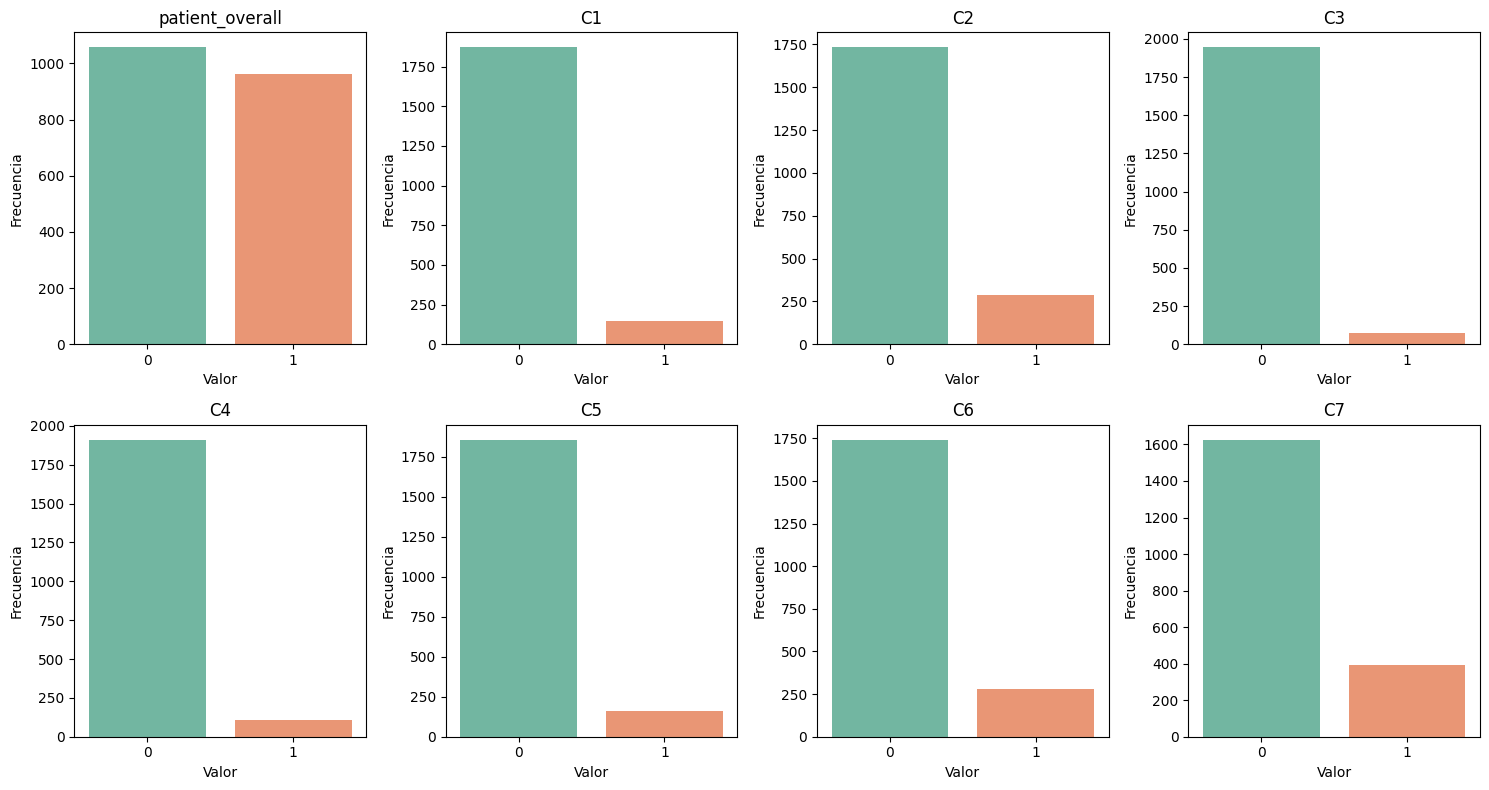

In [18]:
binary_cols = ["patient_overall", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]


print(train_df[binary_cols].mean())

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(binary_cols):
    sns.countplot(data=train_df, x=col, ax=axes[i], palette="Set2")
    axes[i].set_title(col)
    axes[i].set_xlabel("Valor")
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Vemos que en el dataset hay más pacientes que no tienen una lesión en la vértebra, aunque la diferencia es mínima. Otros detalles interesante es que las lesiones más frecuentes son en la vértebra C7, C6 y C2 y que las lesiones en las vértebras C3 y C4 son menos comunes. 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


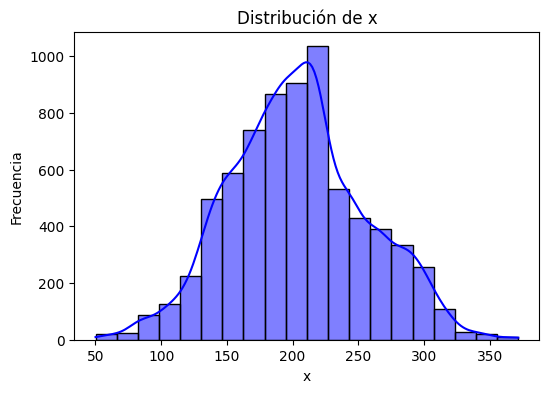

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


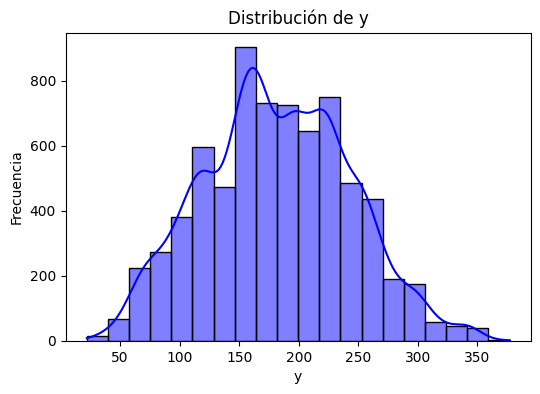

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


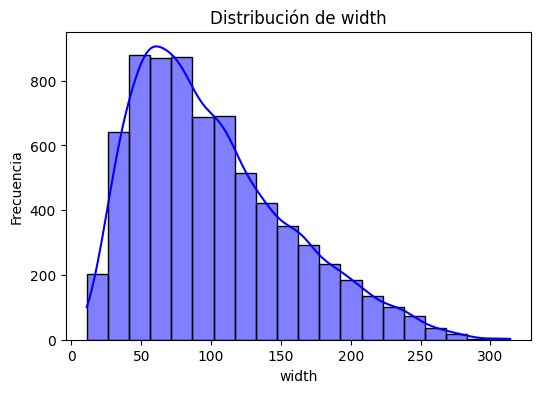

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


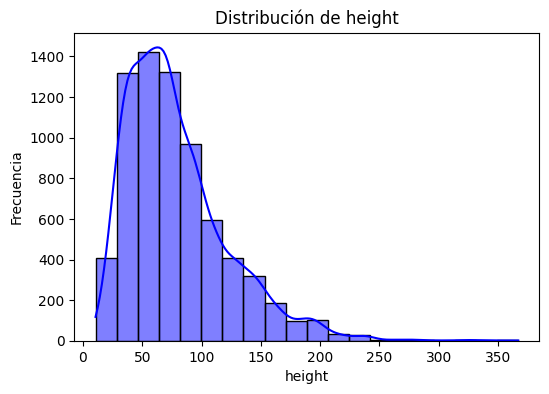

In [19]:
cols = ['x', 'y', 'width', 'height']

plot_histogram(cols, df_train_bounding_boxes)

In [20]:
df_train_bounding_boxes.describe()

,x,y,width,height,slice_number
count,7217.000000,7217.000000,7217.000000,7217.000000,7217.000000
mean,203.919471,181.803096,100.916069,78.787244,191.094222
std,51.855559,61.601498,54.948263,42.884778,94.565947
min,50.080550,22.062000,11.000000,10.632710,26.000000
25%,168.611300,139.000000,57.565400,47.411080,128.000000
50%,202.000000,180.000000,89.307160,70.000000,173.000000
75%,237.000000,225.000000,133.712010,99.000000,234.000000
max,371.818180,377.000000,313.657690,367.029210,483.000000


Vemos que cada límite tiene una media y mediana similares, lo que indica que los datos no están muy dispersos y la mayoría de vérteberas casi siempre se encuentra en la misma posición aunque hay algunas excepciones. 

Finalmente, analizamos las variables numéricas de las imágenes

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


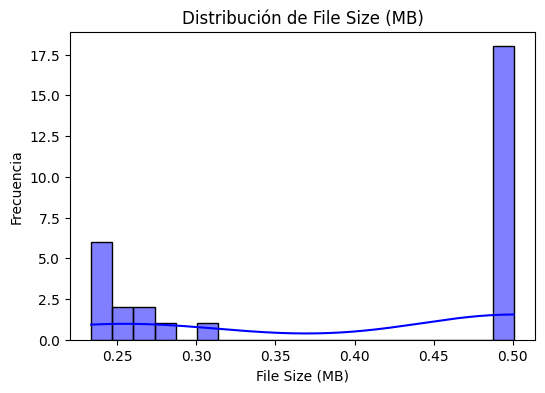

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


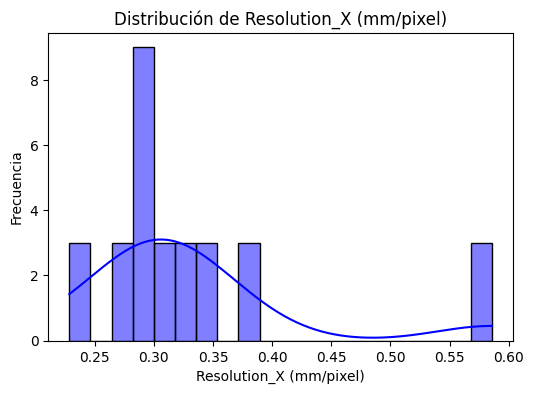

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


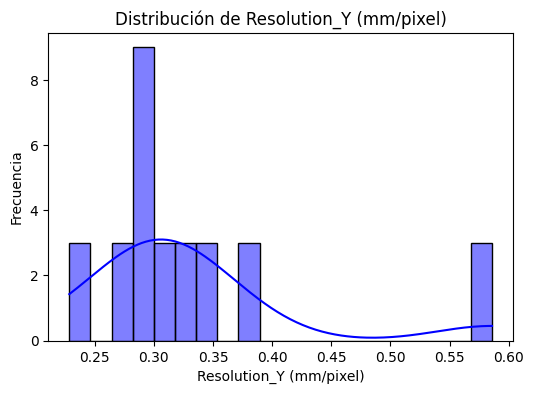

In [21]:
stats_cols = ['File Size (MB)', 'Resolution_X (mm/pixel)', 'Resolution_Y (mm/pixel)' ]
plot_histogram(stats_cols, stats_df)

In [22]:
stats_df.describe()

,File Size (MB),Resolution_X (mm/pixel),Resolution_Y (mm/pixel)
count,30.000000,30.000000,30.000000
mean,0.402913,0.333316,0.333316
std,0.122601,0.093944,0.093944
min,0.233538,0.228516,0.228516
25%,0.260263,0.285156,0.285156
50%,0.500712,0.306703,0.306703
75%,0.500734,0.341797,0.341797
max,0.500738,0.585938,0.585938


De nuestra muestra aleatoria, casi todas las imágenes pesan lo mismo y casi todas tienen la misma resolución aunque se puede observar que hay algunas imágenes que se salen de la norma y tienen más resolución y pesan un poco más. La diferencia si es significativa pues hay una imagen que pesa 50MB mientras que las otras siempre están cerca de los 25 MB. También vemos que hay imágenes con una resolución mayor al resto. 

### Resumen de variables categóricas. 

De el dataset con las lesiones en cada vérterbra, solo el id del estudio es una variable categórica, vamos a ver si hay estudios que se repiten en este dataset.

In [23]:
train_df["StudyInstanceUID"].value_counts().head(5)

StudyInstanceUID
1.2.826.0.1.3680043.6200     1
1.2.826.0.1.3680043.29807    1
1.2.826.0.1.3680043.15845    1
1.2.826.0.1.3680043.20639    1
1.2.826.0.1.3680043.21167    1
Name: count, dtype: int64

La función value_counts ordena por defecto de mayor a menor, por lo tanto vemos que no hay estudios repetidos en este dataset. 

Ahora vamos con las posiciones de las vértebras. 

In [24]:
df_train_bounding_boxes["StudyInstanceUID"].value_counts().head(5)

StudyInstanceUID
1.2.826.0.1.3680043.5783     167
1.2.826.0.1.3680043.25772    166
1.2.826.0.1.3680043.31077    143
1.2.826.0.1.3680043.21321    132
1.2.826.0.1.3680043.19778    100
Name: count, dtype: int64

En este dataset vemos que si hay valores repetidos y que hay una evaluación de la cuál se tomaron 167 medidas. 

Finalmente, vamos a visualizar una muestra de nuestras imágenes. 

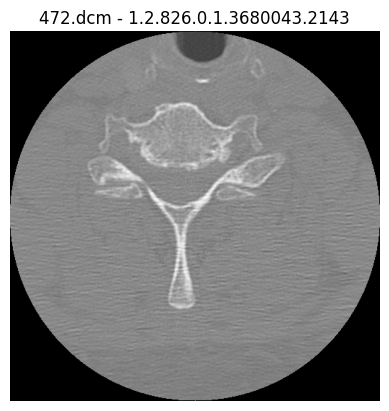

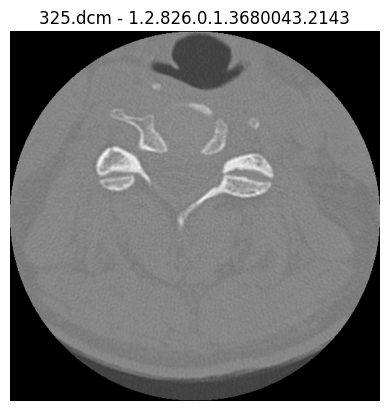

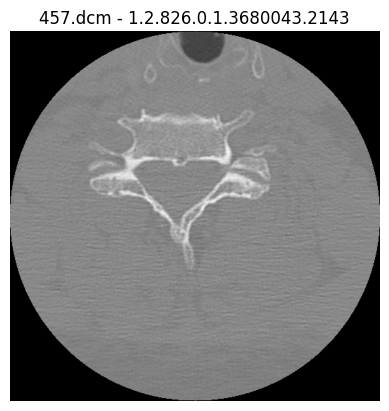

In [25]:
for file in chosen_files:
    ds = pydicom.dcmread(file)
    plt.imshow(ds.pixel_array, cmap="gray")
    plt.title(f"{os.path.basename(file)} - {ds.StudyInstanceUID}")
    plt.axis("off")
    plt.show()

### Cruce de Variables

Ahora vamos a proceder con el cruce de nuestras variables, para poder determinar si existe alguna correlacion mas compleja que no se ha analizado


Distribución de pacientes con fractura:
patient_overall
0    0.524022
1    0.475978
Name: proportion, dtype: float64

Frecuencia de fractura por vértebra:
C1    0.072313
C2    0.141159
C3    0.036157
C4    0.053492
C5    0.080238
C6    0.137197
C7    0.194651
dtype: float64


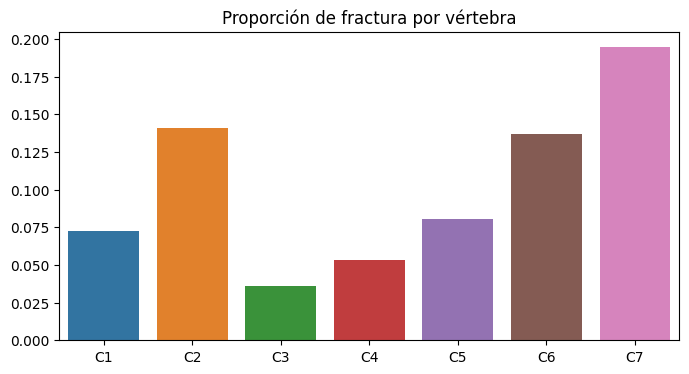

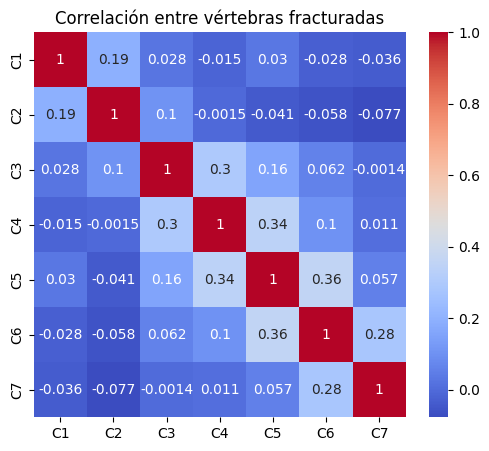

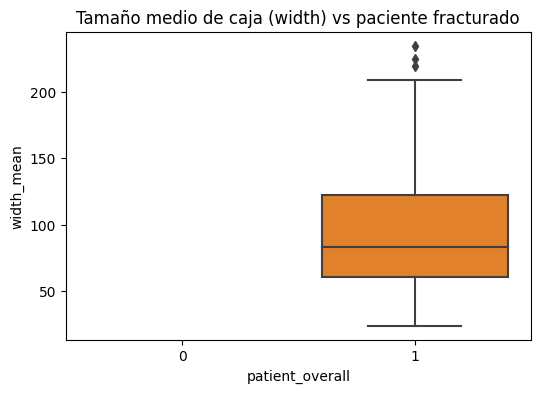

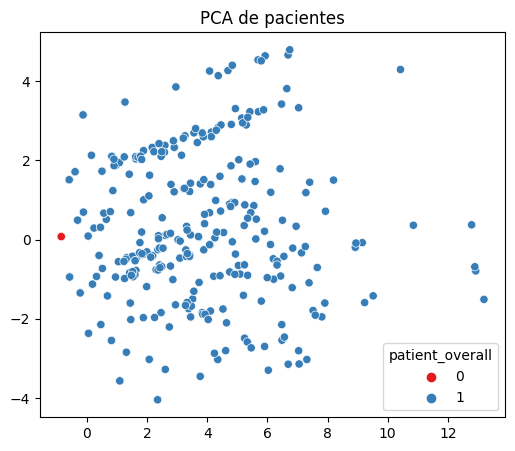

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

Silhouette scores: [(2, 0.6224133986999673), (3, 0.46807458512403693), (4, 0.5527734533292123), (5, 0.5745227493033784)]
Mejor número de clusters: 2


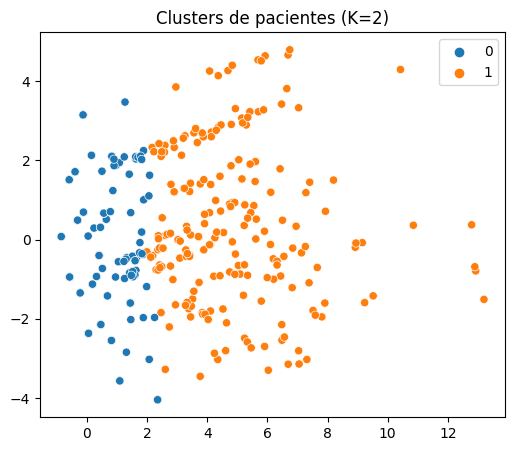

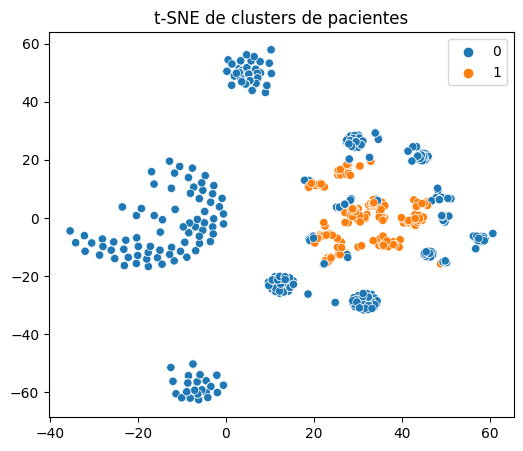

In [26]:



print("Distribución de pacientes con fractura:")
print(train_df['patient_overall'].value_counts(normalize=True))

print("\nFrecuencia de fractura por vértebra:")
print(train_df.loc[:, "C1":"C7"].mean())

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=train_df.loc[:, "C1":"C7"].mean().index, 
            y=train_df.loc[:, "C1":"C7"].mean().values)
plt.title("Proporción de fractura por vértebra")
plt.show()



corr = train_df.loc[:, "C1":"C7"].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlación entre vértebras fracturadas")
plt.show()



# Agregar métricas de bounding boxes por estudio
bbox_agg = df_train_bounding_boxes.groupby("StudyInstanceUID").agg({
    "width": ["mean","std"],
    "height": ["mean","std"],
    "x": ["mean"],
    "y": ["mean"],
    "slice_number": "count"
})
bbox_agg.columns = ["_".join(col).strip() for col in bbox_agg.columns.values]

# Unir con etiquetas
merged = train_df.merge(bbox_agg, on="StudyInstanceUID", how="left")

# Comparar tamaño de cajas en pacientes fracturados vs no fracturados
plt.figure(figsize=(6,4))
sns.boxplot(x="patient_overall", y="width_mean", data=merged)
plt.title("Tamaño medio de caja (width) vs paciente fracturado")
plt.show()



features = ["C1","C2","C3","C4","C5","C6","C7",
            "width_mean","height_mean","slice_number_count"]

X = merged[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=merged["patient_overall"], palette="Set1")
plt.title("PCA de pacientes")
plt.show()

# ===============================================
# 6. CLUSTERIZACIÓN K-MEANS
# ===============================================

# Determinar número óptimo de clusters con silhouette
sil_scores = []
for k in range(2,6):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append((k,sil))

print("Silhouette scores:", sil_scores)

# Elegir el mejor k
best_k = max(sil_scores, key=lambda x: x[1])[0]
print("Mejor número de clusters:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
merged["cluster"] = clusters

# Visualizar clusters con PCA
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="tab10")
plt.title(f"Clusters de pacientes (K={best_k})")
plt.show()


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette="tab10")
plt.title("t-SNE de clusters de pacientes")
plt.show()






In [27]:
print(merged.groupby("cluster")["patient_overall"].value_counts(normalize=True))
print(merged.groupby("cluster")[["width_mean","height_mean","slice_number_count"]].mean())
print(merged.groupby("cluster")[["C1","C2","C3","C4","C5","C6","C7"]].mean())


cluster  patient_overall
0        0                  0.582599
         1                  0.417401
1        1                  1.000000
Name: proportion, dtype: float64
         width_mean  height_mean  slice_number_count
cluster                                             
0         50.542849    39.899831            9.628571
1        101.791158    77.409067           34.400000
               C1        C2        C3        C4        C5        C6        C7
cluster                                                                      
0        0.057269  0.126101  0.012115  0.023128  0.049009  0.107379  0.177863
1        0.206897  0.275862  0.251232  0.325123  0.359606  0.403941  0.344828


#### Analisis

Podemos ver que de lo analizado en correlacion hay unas vertebras que mas se fracturan . Que es la C7 y la C2. Tambien se realizo un grafico el cual es de la matriz de correlacion es que la vertebra C2 tiene una alta correlacion con las vertebras C5,C6 y C7. La alta correlación de la C2 con C5, C6 y C7 podría indicar que cuando hay fractura en C2, es más probable que también se vean comprometidas otras vértebras adyacentes o cercanas en la parte baja de la columna cervical.


En pacientes fracturados, los bounding boxes presentan un promedio de ancho cercano a 100 píxeles.
Mientras que en pacientes no fracturados, la distribución de anchos tiende a ser más dispersa y con valores menores.
Esta diferencia en la distribución, reflejada en el boxplot, podría indicar que las vértebras fracturadas tienden a ocupar un área mayor en la imagen o que el proceso de anotación refleja cambios estructurales relacionados con la fractura.


La clusterizacion nos arrojo 2 grupos. 


- Cluster 0

58% no fracturados / 42% fracturados → es un grupo mixto, pero con mayoría sin fractura.

Bounding boxes pequeños → ancho ≈ 50, alto ≈ 40, slices ≈ 10.

Baja frecuencia de fractura en vértebras (todas < 20%).

Este grupo representa a los pacientes sin fracturas o con fracturas leves y localizadas.


- Cluster 1

100% fracturados → es un grupo exclusivo de pacientes fracturados.

Bounding boxes grandes → ancho ≈ 100, alto ≈ 77, slices ≈ 34 (mucho mayor extensión en las imágenes).

Alta frecuencia de fractura en todas las vértebras → especialmente C5 (36%), C6 (40%), y C7 (34%).

Este grupo representa a los pacientes con fracturas severas y múltiples vértebras afectadas, con cambios estructurales que hacen que las cajas sean mucho más grandes


Por lo tanto tenemos a que los pacientes que tienen fracturas llegan a ocupar mas pixeles de la imagen y a estar mas amplio la misma. En cambio aquellos que no la imagen suele ser mas angosta. Esto incluyendo que las vertebras con mayor correlacion de fracturas son C2,C5,C6,C7, lo cual se debe a que una vertebra puede llegar a causar la quebradura de las vecinas
